Loading the libraries .

In [2]:
#installing the libraries for the assignment
!pip install glymur
!pip install nibabel
!pip install scikit-image

Importing libraries

In [3]:
#Importing libraries
import cv2
import math
import numpy as np
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import glymur as gly
import nibabel as nbl
from skimage.metrics import structural_similarity as ssimindex


Importing google drive for uploading 3dimage data

In [4]:
# importing the google drive for loading nii data of lung ct image
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading the ctimage of lungs and displaying the image and properties of it.



ctimage shape: (325, 512, 512)
img intensity min.: -933.0  max.: 2675.0
float64


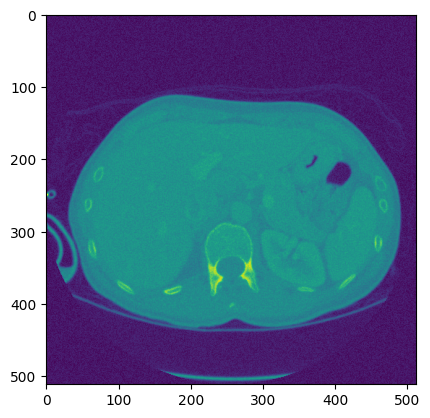

In [6]:

#loading the image using nibabel library
ctimage = nbl.load('/content/drive/MyDrive/3dimage jpeg compression/input 3d images/IMG_0002.nii.gz').get_fdata()
#ctimage = ctimage.astype(np.int16)

#printing the ct image shape
print('\nctimage shape:', ctimage.shape)
#max and min of ct images
print('img intensity min.:', np.min(ctimage), ' max.:', np.max(ctimage))
# Displaying the slice
#cv2_imshow( ctimage[2])
plt.imshow(ctimage[2])
print(ctimage.dtype)

**Preprocessing:**

Histogram equalization applied to the original image and stored as 'ctimagehistequ'.

Multiplying the max value (2^n - 1) makes the data n-bit.

float64
img intensity min.: 82.99873352050781  max.: 65535.0


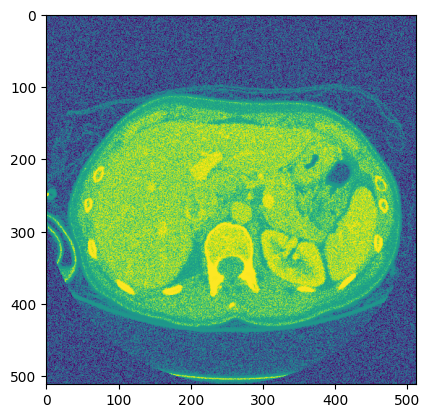

In [7]:
import numpy as np
from skimage import exposure

def histogram_equalization_3d(volume):
    equalized_volume = np.zeros_like(volume)

    for i in range(volume.shape[0]):
        # Apply histogram equalization to each 2D slice
        equalized_volume[i] = exposure.equalize_hist(volume[i])

    return equalized_volume


# Apply histogram equalization
ctimagehistequ = histogram_equalization_3d(ctimage)*65535

plt.imshow(ctimagehistequ[2])
print(ctimagehistequ.dtype)
print('img intensity min.:', np.min(ctimagehistequ), ' max.:', np.max(ctimagehistequ))


**Preprocessing**

Contrast stretching is applied to the original image and stored it as 'ctimageconstretch.'
Multiplying the max value (2^n - 1) while stretching makes the data n-bit.

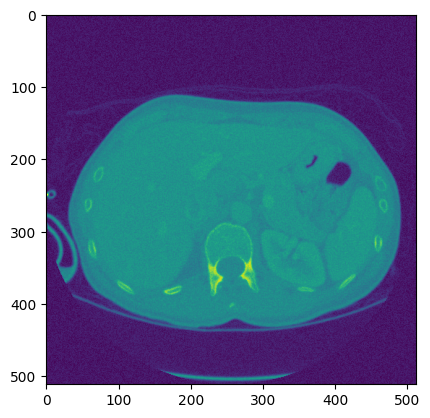

In [8]:
#ctimage=np.array(ctimage,dtype=np.uint16)
def normalize(f):
  lmin = float(f.min())
  lmax = float(f.max())
  #print(lmax)
  #print(lmin)
  return np.floor(((f-lmin)/(lmax-lmin)) * 65535)
def contrast_stretching_3d(volume):
   normalizedimage=np.zeros_like(volume)
   for i in range(volume.shape[0]):
    normalizedimage[i]=normalize(volume[i])
   return normalizedimage
ctimageconstretch=contrast_stretching_3d(ctimage)
plt.imshow(ctimageconstretch[2])





uint16


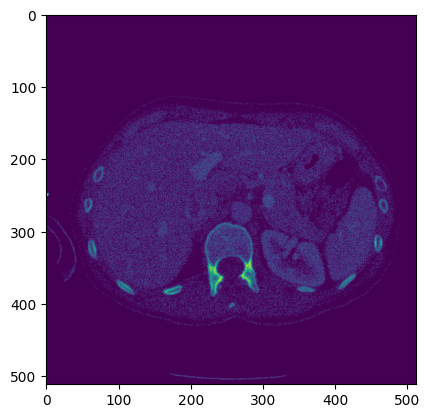

In [9]:
#converting the data type to int 16
#ctimagefinal=np.array(ctimage,dtype=np.uint16)
ctimagefinal = np.clip(ctimage, 0, 65535).astype(np.uint16)
print(ctimagefinal.dtype)
#np.save('/content/drive/MyDrive/ctnumpydata',ctimage)
plt.imshow(ctimagefinal[2])


**Encoding:**

Converting 3d image data  to jp2 format.

In [10]:
#jp2k is a function operates on numpy , jpeg200 formats for encoding and decoding

from glymur import Jp2k

# Assuming 'image_data' is a NumPy array containing your image data
# 'image_data' should be in uint16 format for JPEG 2000

# Define the output file path
output_filepath = '/content/drive/MyDrive/encoded_ctimagesof_4_compressedversions.jp2'

# Create a Jp2k file by encoding the ctimage format from numpy to jp2
jp2 = Jp2k(output_filepath, data=ctimagefinal,cratios=[70, 40,10, 1])

print("jpeg2000 file is saved  in ",output_filepath)


jpeg2000 file is saved  in  /content/drive/MyDrive/encoded_ctimagesof_4_compressedversions.jp2


Reading the jpeg200 file

(325, 512, 512)


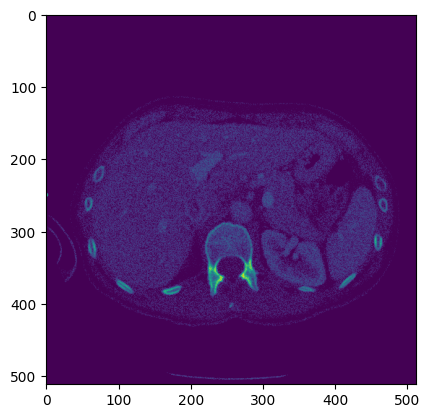

In [12]:
#reading the jpeg2000 file
lung_ct_image = Jp2k('/content/drive/MyDrive/3dimage jpeg compression/outputs/encoded_ctimage.jp2')
print(lung_ct_image[:].shape)
plt.imshow(lung_ct_image[1])

**Decoding:**

Converting jp2 format of encoded(compressed) image   to image format.

In [13]:
# Step 2: Decoding the jp2 format to image format

# Load the encoded JPEG 2000 image
encoded_ct_image = Jp2k(output_filepath)

#selecting the layer2 of 70 percent compressed as we have multiple images
encoded_ct_image.layer=2

# Decode the image
decoded_data = encoded_ct_image[:]


Displaying the decoding  image after compression.

(325, 512, 512)
img intensity min.: 0  max.: 2722


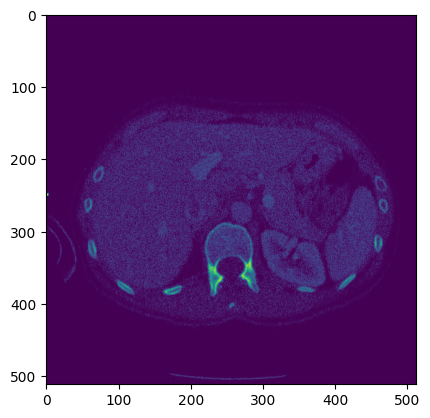

In [14]:
print(decoded_data.shape)

print('img intensity min.:', np.min(decoded_data), ' max.:', np.max(decoded_data))
# Display
#cv2_imshow( decoded_data[2])
plt.imshow(decoded_data[2])

For different compression ratios,the psnr values calculated between original and compressed images.

In [15]:
import skimage
psnr = []
for layer in range(4):
    jp2.layer = layer
    psnr.append(skimage.metrics.peak_signal_noise_ratio(ctimagefinal, jp2[:]))
print(psnr)


/usr/local/lib/python3.10/dist-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


[inf, 68.91814437233958, 71.06774779388911, 89.99810190641917]


**PSNR function implementation:**

In [16]:
#PSNR is the ratio between signal's maximum power and signals noise[original-approximated] power
#It is a metric used to measure the quality of approximation
def get_max_pixel_value(data_type):
    if data_type == np.uint8:
        return 255
    elif data_type == np.uint16:
        return 65535
    elif data_type == np.unint4:
        return 15

    else:
        raise ValueError(f"Unsupported data type: {data_type}")

def psnr(original,approximated):
  noise=original-approximated
  noisepower=np.mean((noise)**2)
  if noisepower==0:
    return 100
  signalspower=get_max_pixel_value(original.dtype)
  psnr = 20 * np.log10(signalspower / np.sqrt(noisepower))
  return psnr






In [17]:
print(psnr(ctimagefinal,decoded_data))

71.06775774037402


Structural similarity index measurement (SSIM)function implementation.

In [18]:

def calculate_ssim_for_3d_images(original_3dimage, reconstructed_3dimage):
    # Loading the 3D image data
    originalctimage = np.array(original_3dimage)
    reconstructedctimage = np.array(reconstructed_3dimage)

    # Initialize an array
    #to store structure similarity index for each ct slice
    #comparing the original with reconstructed
    ssim_valuesof_all_slices = []

    # Iterate through slices
    for i in range(originalctimage.shape[0]):
        ssim_slice = ssimindex(originalctimage[i], reconstructedctimage[i])
        ssim_valuesof_all_slices.append(ssim_slice)

    # Calculate the mean SSIM across all slices
    mean_ssim = np.mean(ssim_valuesof_all_slices)

    return mean_ssim

# Example usage
ssim_index = calculate_ssim_for_3d_images(ctimagefinal,decoded_data)
print(f'Mean SSIM for 3D image: {ssim_index}')


Mean SSIM for 3D image: 0.9998893132092144


SSIM function for different compressed images.

In [19]:
import skimage
ssim = []
for layer in range(4):
    jp2.layer = layer
    ssim.append(calculate_ssim_for_3d_images(ctimagefinal, jp2[:]))
print(ssim)


[1.0, 0.9998180845342337, 0.9998893132092144, 0.999998277354498]


Implemented a function such that given a preprocessed image and compression ratio.It will do the encoding ,decoding and measures the quality through PSNR & SSIM between original image and compressed image.

In [21]:
def finalobservations(preprocessed_image,compression_ratio):
  output_file = 'encoded_ctimagefinal.jp2'
  jp2final = Jp2k(output_file, data=preprocessed_image,cratios=[compression_ratio])
  # Step 2: Decoding the jp2 format to image format
  # Load the encoded JPEG 2000 image
  encoded_imagefinal = Jp2k(output_file)
  # Decode the image
  decoded_data = encoded_imagefinal[:]
  ssim_index = calculate_ssim_for_3d_images(preprocessed_image,decoded_data)
  print(f'Mean SSIM for 3D image: {ssim_index}')
  psnrvalue=psnr(preprocessed_image,decoded_data)
  print(f' psnr for 3D image: {psnrvalue}')

finalobservations(ctimagefinal,70)





Mean SSIM for 3D image: 0.9998180845342337
 psnr for 3D image: 68.91821713250415
